In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()

## Plot Darcy modes ablation

In [3]:
# frequency mode ablation
project_name = "crwhite/lowprecision"
# darcy cp, rank=0.05, half/full, modes=16/32/64/128
ids = {
    '1kaypmft', # 16 half seed 1
    'sggojsh8',
    'fx73zf6v',
    '7vjt6uxb',
    'a0exhpxj',
    'gn0eedfm',
    'luyfrrqk',
    'fnsuh4u4', # 128 full seed 1
    'oaszhbyr',
    '3aru3gzx',
    '0t2rgixj',
    'ugpjzm1n',
    'rih77la9',
    'kaaoiieg',
    '7rd8f88h',
    'u2y1gfsv', # 128 full seed 2
    '2d1d6fl3',
    'xpwxwdh5',
    'gdusuu9g',
    'x6w5n445',
    'y92pq1nq',
    '307vl5x4',
    'mpn0w1xf',
    'tynr6a76', # 128 full, seed 3
}

#metrics = ["time", "128_h1", "128_l2", "train_error"]


In [4]:
raw_data = {}
i = 0
for exp_id in ids:
    run = wandb.Api().run(f"{project_name}/{exp_id}")
    raw_data[exp_id] = run

In [5]:
modes = [16, 32, 64, 128]
sorted_data = {'half': {}, 'full': {}}
for key in sorted_data:
    for mode in modes:
        sorted_data[key][mode] = []

for _, run in raw_data.items():
    precision = 'half' if run.config['tfno2d']['half_prec_fourier'] else 'full'
    mode = run.config['tfno2d']['n_modes_height']
    sorted_data[precision][mode].append(run.history())
    #print(run.summary['time'])
    #print(np.mean(run.history()['time']))
    #print(run.history()['128_l2'][-5:])
    #print(np.mean(run.history()['128_l2'][-5:]))

In [6]:
def plot_pareto_curve(sorted_data, legend_loc, dataset='Darcy Flow', 
                      sliding_window_length=1, metric = '128_l2', save_name=None):
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', 8)

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    i = 0
    for mode in modes:
        for precision in sorted_data:

            #print(sorted_data[precision][mode][0]['time'])
            times = [np.mean(result['time']) for result in sorted_data[precision][mode]]
            mean_time = np.mean(times)
            std_time = np.std(times)
            losses = [np.mean(result[metric][-sliding_window_length:]) for result in sorted_data[precision][mode]]
            mean_loss = np.mean(losses)
            std_loss = np.std(losses)

            color = colors(i)
            #method = precision + str(mode)
            method = 'Half Precision,' if precision=='half' else 'Full Precision,'
            method += ' ' + str(mode) + ' Modes'
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
            plt.scatter(mean_time, mean_loss, color=method_legend_handles[method].get_facecolor()[0])
            t = mean_time
            ell = mean_loss

            # plot stds
            x1 = [t - std_time, t + std_time]
            y1 = [ell, ell]
            x2 = [t, t]
            y2 = [ell - std_loss, ell + std_loss]
            plt.plot(x1, y1, marker='', color=color, linewidth=4.5)
            plt.plot(x2, y2, marker='', color=color, linewidth=4.5)

            if i % 2 == 0:
                prev_time = mean_time
                prev_loss = mean_loss
            if i % 2 == 1:
                x1 = [t,prev_time]
                y1 = [ell,prev_loss]
                plt.plot(x1, y1, marker='', color='black', linestyle='dashed', linewidth=1.5)
            
            i += 1

    plt.xlabel('Time per Epoch (seconds)', fontsize=16)
    if metric == '128_h1':
        plt.ylabel('H1 Loss', fontsize=16)
        plt.title('H1 Loss vs. Runtime, {}'.format(dataset), fontsize=20)
    elif metric == '128_l2':
        plt.ylabel('L2 Loss', fontsize=16)
        plt.title('L2 Loss vs. Runtime, {}'.format(dataset), fontsize=20)
        
    #plt.xscale('log')
    #plt.yscale('log')

    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14, loc=legend_loc)
    
    plt.grid(False)
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, format='pdf')
    plt.show()

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/1730716530.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


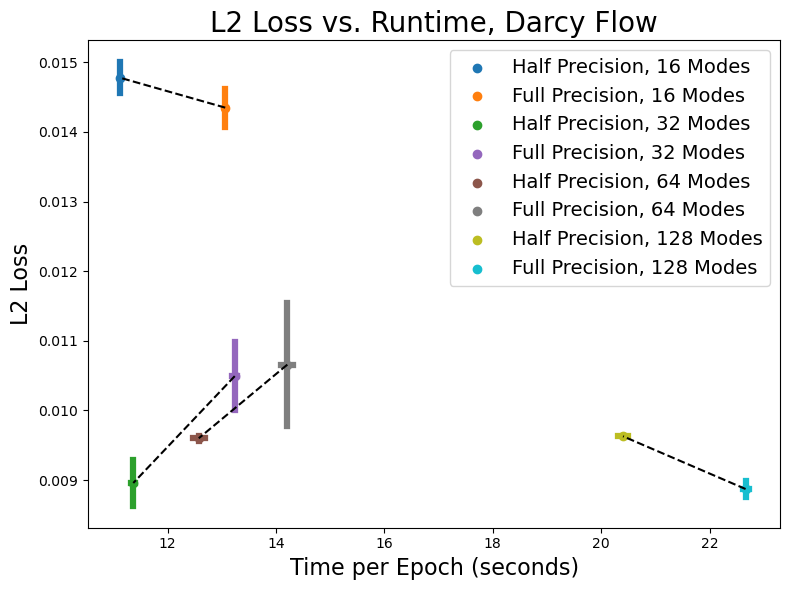

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/1730716530.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


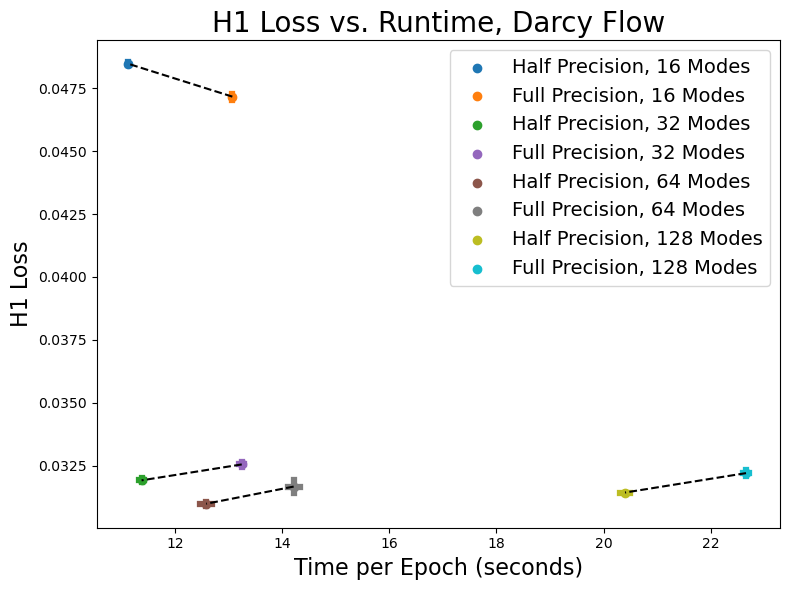

In [7]:
plot_pareto_curve(sorted_data, legend_loc='best', save_name='Darcy_mode_ablation_l2.pdf', metric='128_l2')
plot_pareto_curve(sorted_data, legend_loc='best', save_name='Darcy_mode_ablation_h1.pdf', metric='128_h1')

## plot Navier stokes, tensorized vs dense

In [8]:
project_name = "crwhite/lowprecision"
# navier stokes, 4layer, half/full, cp/dense
ids = {
    '3vyiewmu', # cp-half-3
    '5vgxtpkk', # cp-half-2
    'sp08bte2', # cp-half-1
    'jw2770ri', # cp-full-3
    '2r1343oy', # cp-full-2
    'lii6bkgt', # cp-full-1
    '4jx15to4', # dense-full-3
    '5squto9e', # dense-full-2
    'gnjbaroy', # dense-full-1
    'c4u82xzx', # dense-half-3
    'nua0wf1u', # dense-half-2
    '5nnvhtkm', # dense-half-1
}


In [9]:
raw_data = {}
i = 0
for exp_id in ids:
    run = wandb.Api().run(f"{project_name}/{exp_id}")
    raw_data[exp_id] = run

In [10]:
factorizations = ['None', 'cp']
sorted_data = {'half': {}, 'full': {}}
for key in sorted_data:
    for factorization in factorizations:
        sorted_data[key][factorization] = []

for _, run in raw_data.items():
    precision = 'half' if run.config['tfno2d']['half_prec_fourier'] else 'full'
    factorization = str(run.config['tfno2d']['factorization'])
    sorted_data[precision][factorization].append(run.history())

In [11]:
# very similar to the one above but with factorization instead of mode
def plot_pareto_curve(sorted_data, legend_loc, dataset='Darcy Flow', 
                      sliding_window_length=1, metric = '128_l2', save_name=None):
    plt.figure(figsize=(8, 6))
    # todo: can be len(sorted_data)
    colors = plt.cm.get_cmap('tab10', 4)

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    i = 0
    for factorization in factorizations:
        for precision in sorted_data:

            #print(sorted_data[precision][mode][0]['time'])
            times = [np.mean(result['time']) for result in sorted_data[precision][factorization]]
            mean_time = np.mean(times)
            std_time = np.std(times)
            losses = [np.mean(result[metric][-sliding_window_length:]) for result in sorted_data[precision][factorization]]
            mean_loss = np.mean(losses)
            std_loss = np.std(losses)

            color = colors(i)
            #method = precision + str(mode)
            method = 'Half Precision,' if precision=='half' else 'Full Precision,'
            method += ' ' + factorization
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
            plt.scatter(mean_time, mean_loss, color=method_legend_handles[method].get_facecolor()[0])
            t = mean_time
            ell = mean_loss

            # plot stds
            x1 = [t - std_time, t + std_time]
            y1 = [ell, ell]
            x2 = [t, t]
            y2 = [ell - std_loss, ell + std_loss]
            plt.plot(x1, y1, marker='', color=color, linewidth=4.5)
            plt.plot(x2, y2, marker='', color=color, linewidth=4.5)

            if i % 2 == 0:
                prev_time = mean_time
                prev_loss = mean_loss
            if i % 2 == 1:
                x1 = [t,prev_time]
                y1 = [ell,prev_loss]
                plt.plot(x1, y1, marker='', color='black', linestyle='dashed', linewidth=1.5)
            
            i += 1

    plt.xlabel('Time per Epoch (seconds)', fontsize=16)
    if metric == '128_h1':
        plt.ylabel('H1 Loss', fontsize=16)
        plt.title('H1 Loss vs. Runtime, {}'.format(dataset), fontsize=20)
    elif metric == '128_l2':
        plt.ylabel('L2 Loss', fontsize=16)
        plt.title('L2 Loss vs. Runtime, {}'.format(dataset), fontsize=20)

    #plt.xscale('log')
    #plt.yscale('log')

    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14, loc=legend_loc)
    
    plt.grid(False)
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, format='pdf')
    plt.show()

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/3143156467.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


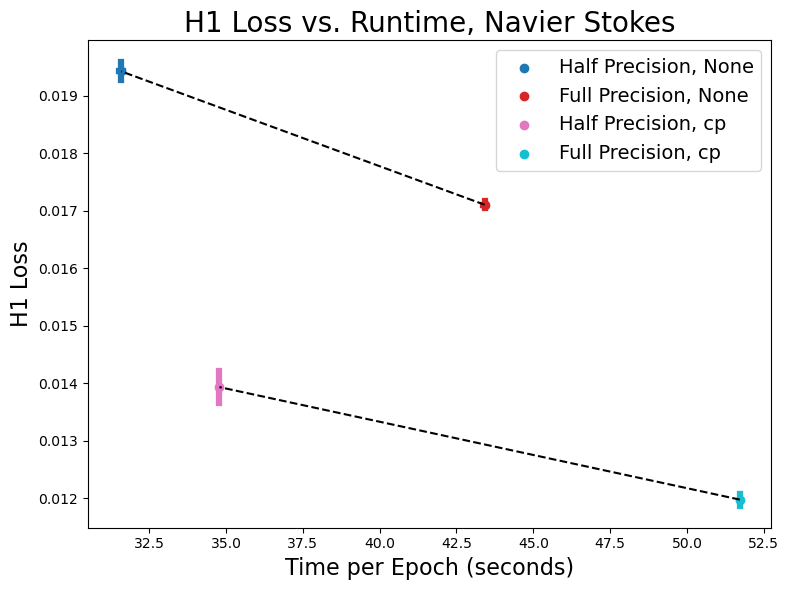

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/3143156467.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


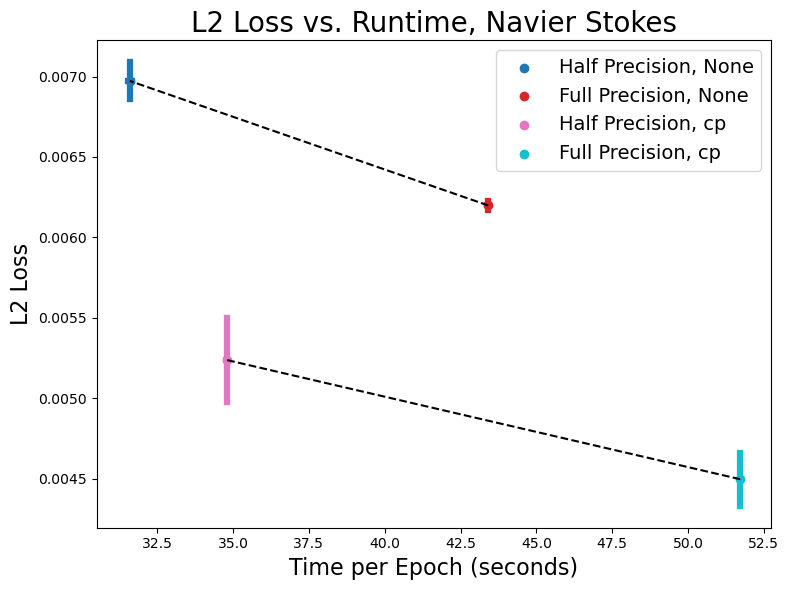

In [12]:
plot_pareto_curve(sorted_data, dataset='Navier Stokes', legend_loc='best', save_name='Pareto_NS_h1.pdf', metric='128_h1')
plot_pareto_curve(sorted_data, dataset='Navier Stokes', legend_loc='best', save_name='Pareto_NS_l2.pdf', metric='128_l2')

# Plot darcy, tensorized vs dense

In [15]:
project_name = "crwhite/lowprecision"
# Darcy, 4layer, mode64, half/full, cp/dense
ids = {
    'hioamcz7', # cp-half-3
    'ne07wp2q', # cp-half-2
    'eu3hfon0', # cp-half-1
    'gn0eedfm', # cp-full-3 # from ablation
    'kaaoiieg', # cp-full-2 # from ablation
    '307vl5x4', # cp-full-1 # from ablation
    '73qch6mn', # dense-full-3
    'ml1sdqwc', # dense-full-2
    'b73fjb53', # dense-full-1
    '2q4k2qcx', # dense-half-3
    'kqz5tl4m', # dense-half-2
    'se0y1l5y', # dense-half-1
}

In [16]:
raw_data = {}
i = 0
for exp_id in ids:
    run = wandb.Api().run(f"{project_name}/{exp_id}")
    raw_data[exp_id] = run

In [17]:
factorizations = ['None', 'cp']
sorted_data = {'half': {}, 'full': {}}
for key in sorted_data:
    for factorization in factorizations:
        sorted_data[key][factorization] = []

for _, run in raw_data.items():
    precision = 'half' if run.config['tfno2d']['half_prec_fourier'] else 'full'
    factorization = str(run.config['tfno2d']['factorization'])
    sorted_data[precision][factorization].append(run.history())

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/3143156467.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


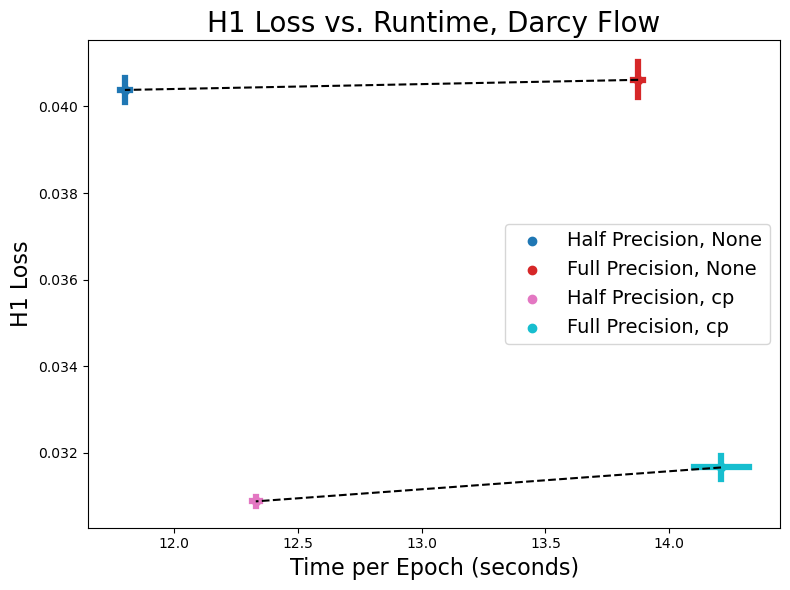

/var/folders/4v/hnwq99yn1kv2xbbc7ksr22840000gn/T/ipykernel_50947/3143156467.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


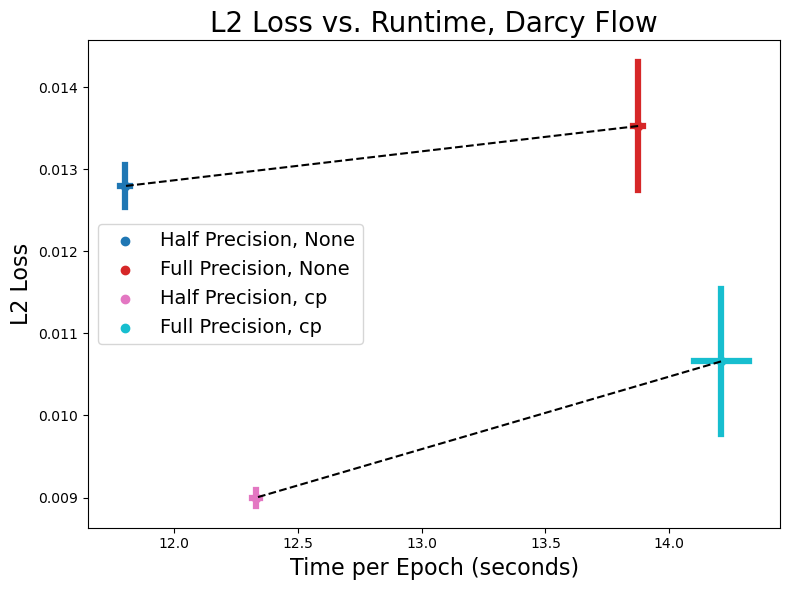

In [18]:
plot_pareto_curve(sorted_data, dataset='Darcy Flow', legend_loc='best', save_name='Pareto_Darcy_h1.pdf', metric='128_h1')
plot_pareto_curve(sorted_data, dataset='Darcy Flow', legend_loc='best', save_name='Pareto_Darcy_l2.pdf', metric='128_l2')

In [ ]:
# todo: change factorization to Dense, CP. 
# make it "mixed precision" or "low precision" consistently?